In [1]:
import sys
import os
import inspect
# add parent dir to system dir
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
root_dir = os.path.dirname(current_dir)
sys.path.insert(0, root_dir)

import numpy as np
import spectral.io.envi as envi
from numpy import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap as ISOMAP
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from hsipy.plot import Scatter

In [2]:
name = "salinas"
classes =  {
    1: {"name": "Brocoli/Green Weeds #1", "color":"darkgreen"},
    2: {"name": "Brocoli/Green Weeds #2", "color":"forestgreen"},
    3: {"name": "Fallow", "color":"burlywood"},
    4: {"name": "Fallow/Rough Plowed", "color":"brown"},
    5: {"name": "Fallow/Smooth Plowed", "color":"peru"},
    6: {"name": "Stubble", "color":"tan"},
    7: {"name": "Celery", "color":"lawngreen"},
    8: {"name": "Untrained Grapes", "color":"darkslateblue"},
    9: {"name": "Vinyard/Developed Soil", "color":"magenta"},
    10: {"name": "Senesced Corn/Green Weeds", "color":"gold"},
    11: {"name": "Romaine Lettuce/4 weeks", "color":"green"},
    12: {"name": "Romaine Lettuce/5 weeks", "color":"limegreen"},
    13: {"name": "Romaine Lettuce/6 weeks", "color":"lime"},
    14: {"name": "Romaine Lettuce/7 weeks", "color":"lightgreen"},
    15: {"name": "Untrained Vinyard", "color":"purple"},
    16: {"name": "Vinyard/Vertical Trellis", "color":"crimson"},
}
# initalize a p-random generator
rnd = np.random.RandomState(2018)

In [3]:
# load hsi image
ffname = os.path.join(root_dir, "hsipy", "datasets","raw",name+".envi.hdr")
img =  envi.open(ffname)
x = img.load()[:, :, 1:]
y = img.load()[:, :, 0]
n_samples, n_lines, n_channels = x.shape

/home/h8147/miniconda3/envs/hsipy-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  after removing the cwd from sys.path.
/home/h8147/miniconda3/envs/hsipy-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """


In [4]:
# reshape image to 2D data
x = x.reshape(-1, n_channels)
y = y.reshape(-1).astype(int)
x = x[y!=0, :]
y = y[y!=0]

In [5]:
y.shape

(54129,)

In [6]:
# resample data/ 500 uniform random samples per class
n_xi = 500 # number of samples per class, if none then skip
if n_xi is not None:
    classids = classes.keys()
    x_ = np.empty(shape=(0, n_channels))
    y_ = np.empty(shape=(0))

    for classid in classids:
        xi = x[y==classid, :]
        yi = y[y==classid]
        indexi = rnd.choice(list(range(len(yi))), n_xi)
        x_ = np.concatenate((x_, xi[indexi, :]), axis=0)
        y_ = np.concatenate((y_, yi[indexi]), axis=0)
    x = x_
    y = y_

In [7]:
n_components = 3

# compute/save/load embeddings: pca, tsne
ffname = os.path.join(root_dir, "hsipy", "datasets","int",
                      name+f".{n_xi}.embeddings.{n_components}.3d".lower())
try:
    embeddings = np.load(ffname+".npz")
    xhat_pca = embeddings["pca"]
    xhat_isomap = embeddings["isomap"]
    xhat_tsne = embeddings["tsne"]
except:
    xhat_pca = PCA(n_components=n_components).fit_transform(X=x)
    xhat_tsne = TSNE(n_components=n_components).fit_transform(X=x)
    xhat_isomap = ISOMAP(n_components=n_components).fit_transform(X=x)
    np.savez_compressed(ffname, pca=xhat_pca, tsne=xhat_tsne, isomap=xhat_isomap, y=y)

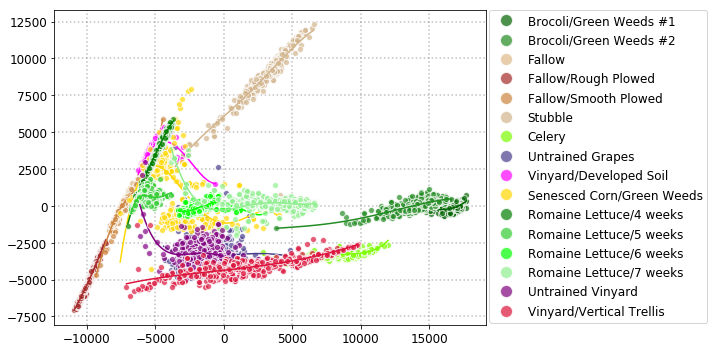

In [8]:
# scatter plot (pca)
xhat = xhat_pca
classids_to_visualize = classids

scatter = Scatter()
scatter.figsize = (12, 9)
scatter.markersize = 6
scatter.markeredgewidth = 1
scatter.markeredgecolor = "white"
scatter.alpha = 0.7

for index, classid in enumerate(classids_to_visualize):
    scatter.markerfacecolor = classes[classid]["color"]
    scatter.label = classes[classid]["name"]
    scatter(xhat[y == classid, 0], xhat[y == classid, 1]) 
#     scatter.ax.set_xticklabels([])
#     scatter.ax.set_yticklabels([])
    
    
    
    polynomial_features = PolynomialFeatures(degree=4, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(xhat[y == classid, 0].reshape(-1, 1),
                 xhat[y == classid, [1]].reshape(-1, 1))
    
    xtild = np.linspace(xhat[y == classid, [0]].min(),
                        xhat[y == classid, [0]].max(),
                        100)
    ytild = pipeline.predict(xtild.reshape(-1, 1))
    
    
    scatter.ax.legend(loc=9,
                      bbox_to_anchor=(1.26, 1.02),
                      ncol=1,
                      markerscale=2,
                      fontsize=12,
                      labelspacing=0.53)
    scatter.ax.plot(xtild, ytild, color=classes[classid]["color"])

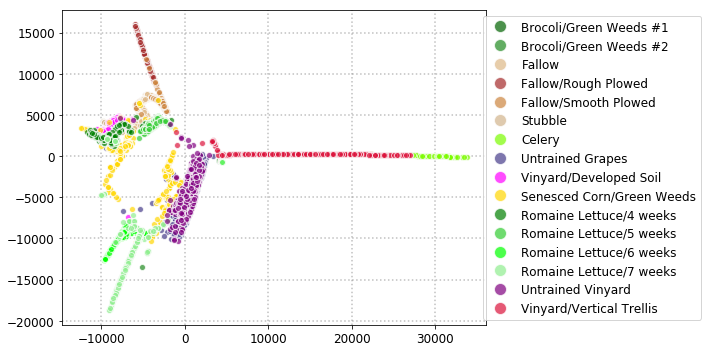

In [9]:
# scatter plot (isomap)
classids_to_visualize = classids

scatter = Scatter()
scatter.figsize = (12, 9)
scatter.markersize = 6
scatter.markeredgewidth = 1
scatter.markeredgecolor = "white"
scatter.alpha = 0.7

for index, classid in enumerate(classids_to_visualize):
    scatter.markerfacecolor = classes[classid]["color"]
    scatter.label = classes[classid]["name"]
    scatter(xhat_isomap[y == classid, 0], xhat_isomap[y == classid, 1]) 
    scatter.ax.legend(loc=9,
                      bbox_to_anchor=(1.25, 1),
                      ncol=1,
                      markerscale=2,
                      fontsize=12,
                      labelspacing=0.48)

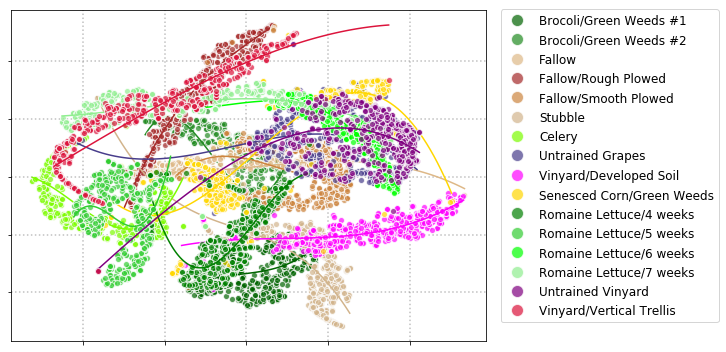

In [10]:
# scatter plot (tsne)
xhat = xhat_tsne
classids_to_visualize = classids

scatter = Scatter()
scatter.figsize = (12, 9)
scatter.markersize = 6
scatter.markeredgewidth = 1
scatter.markeredgecolor = "white"
scatter.alpha = 0.7

for index, classid in enumerate(classids_to_visualize):
    scatter.markerfacecolor = classes[classid]["color"]
    scatter.label = classes[classid]["name"]
    scatter(xhat[y == classid, 0], xhat[y == classid, 1]) 
    scatter.ax.set_xticklabels([])
    scatter.ax.set_yticklabels([])
    
    
    
    polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(xhat[y == classid, 0].reshape(-1, 1),
                 xhat[y == classid, [1]].reshape(-1, 1))
    
    xtild = np.linspace(xhat[y == classid, [0]].min(),
                        xhat[y == classid, [0]].max(),
                        100)
    ytild = pipeline.predict(xtild.reshape(-1, 1))
    
    
    scatter.ax.legend(loc=9,
                      bbox_to_anchor=(1.26, 1.02),
                      ncol=1,
                      markerscale=2,
                      fontsize=12,
                      labelspacing=0.53)
    scatter.ax.plot(xtild, ytild, color=classes[classid]["color"])

In [11]:
xtild[:,  np.newaxis].shape

(100, 1)

In [12]:
xhat[y == classid, [0]].shape

(500,)